In [1]:
import pandas as pd

## Load & Parse Files:

In [2]:
file_path = r"C:\Users\ISMAIMZ\OneDrive - Hapag-Lloyd AG\Documents\Books\Projects\Named Entity Recognition (NER)"

def load_conll_data(filepath):
    sentences = []
    labels = []
    sentence = []
    label = []

    with open(filepath, "r", encoding="utf-8") as f:
        for line in f:
            if line.strip() == "":
                if sentence:
                    sentences.append(sentence)
                    labels.append(label)
                    sentence = []
                    label = []

            else:
                parts = line.strip().split()
                word = parts[0]
                tag = parts[-1]
                sentence.append(word)
                label.append(tag)
    return sentences, labels

train_sentences, train_labels = load_conll_data("train.txt")
valid_sentences, valid_labels = load_conll_data("valid.txt")
test_sentences, test_labels = load_conll_data("test.txt")

print(train_sentences[0])
print(train_labels[0])

['-DOCSTART-']
['O']


## Build Vocab & Label Map

In [3]:
from collections import Counter

word_counts = Counter([w for s in train_sentences for w in s])
vocab = {w: i+2 for i, (w, _) in enumerate(word_counts.most_common())}
vocab["<PAD>"] = 0
vocab["<UNK>"] = 1

unique_labels = set([l for seq in train_labels for l in seq])
label2id = {l: i for i, l in enumerate(sorted(unique_labels))}
id2label = {i: l for l, i in label2id.items()}

## Convert Sentences to IDs

In [4]:
MAX_LEN = 100

def encode(sentences, labels, vocab, label2id, max_len=MAX_LEN):
    X = []
    y = []
    for s, l in zip(sentences, labels):
        word_ids = [vocab.get(w, vocab["<UNK>"]) for w in s]
        label_ids = [label2id[tag] for tag in l]

        word_ids = word_ids[:max_len] + [vocab["<PAD>"]] * (max_len - len(word_ids))
        label_ids = label_ids[:max_len] + [label2id["O"]] * (max_len - len(label_ids))

        X.append(word_ids)
        y.append(label_ids)
    return X, y

X_train, y_train = encode(train_sentences, train_labels, vocab, label2id)
X_valid, y_valid = encode(valid_sentences, valid_labels, vocab, label2id)
X_test, y_test = encode(test_sentences, test_labels, vocab, label2id)

## Convert to TensorFlow Dataset

In [5]:
import tensorflow as tf

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
valid_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

## Setup

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

vocab_size = len(vocab)
embedding_dim = 128
max_len = 100
num_tags = len(label2id)
batch_size = 32
epochs = 50

## Basic Embedding + Dense

In [7]:
inputs = layers.Input(shape=(max_len,))
embeddings = layers.Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs)
outputs = layers.TimeDistributed(layers.Dense(num_tags, activation="softmax"))(embeddings)

model = models.Model(inputs, outputs)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 128)  │  3,024,128 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 100)       │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 100, 9)    │      1,161 │ embedding[0][0],  │
│ (TimeDistributed)   │                   │            │ not_equal[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,025,289 (11.54 MB)

 Trainable params: 3,025,289 (11.54 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2)
]

history = model.fit(
    np.array(X_train), np.array(y_train),
    validation_data=(np.array(X_valid), np.array(y_valid)),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 37s 69ms/step - accuracy: 0.9858 - loss: 0.7522 - val_accuracy: 0.9833 - val_loss: 0.4432 - learning_rate: 0.0010
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 30s 64ms/step - accuracy: 0.9955 - loss: 0.2170 - val_accuracy: 0.9838 - val_loss: 0.3245 - learning_rate: 0.0010
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 29s 62ms/step - accuracy: 0.9961 - loss: 0.1129 - val_accuracy: 0.9838 - val_loss: 0.3093 - learning_rate: 0.0010
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 29s 62ms/step - accuracy: 0.9961 - loss: 0.0884 - val_accuracy: 0.9838 - val_loss: 0.3095 - learning_rate: 0.0010
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 33s 70ms/step - accuracy: 0.9961 - loss: 0.0811 - val_accuracy: 0.9838 - val_loss: 0.3117 - learning_rate: 0.0010
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 34s 71ms/step - accuracy: 0.9962 - loss: 0.0744 - val_accuracy: 0.9838 - val_loss: 0.3117 - learning_rate: 5.0000e-04


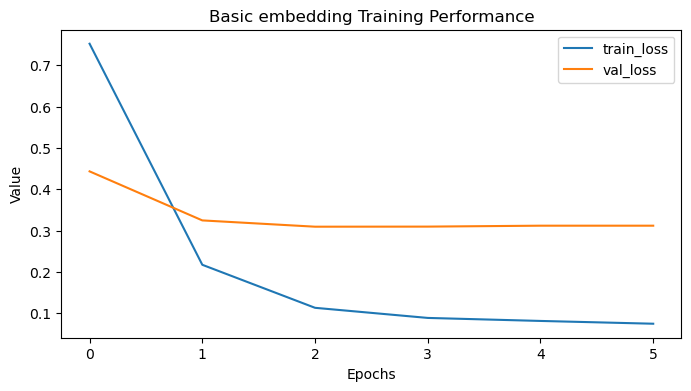

In [9]:
import matplotlib.pyplot as plt

def plot_history(history, title):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

plot_history(history, "Basic embedding Training Performance")

In [10]:
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score

def evaluate_model(model, X, y_true, id2label):
    preds = model.predict(np.array(X))
    pred_tags = [[id2label[i] for i in np.argmax(p, axis=-1)] for p in preds]
    true_tags = [[id2label[i] for i in seq] for seq in y_true]

    print("Precision:", precision_score(true_tags, pred_tags))
    print("Recall:", recall_score(true_tags, pred_tags))
    print("F1-score:", f1_score(true_tags, pred_tags))
    print("\nDetailed Report:\n", classification_report(true_tags, pred_tags))

evaluate_model(model, X_test, y_test, id2label)

116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
Precision: 0.3064098878988215
Recall: 0.5668202764976958
F1-score: 0.39778593196094286

Detailed Report:
               precision    recall  f1-score   support

         LOC       0.74      0.75      0.75      1665
        MISC       0.63      0.64      0.63       702
         ORG       0.16      0.68      0.26      1661
         PER       0.36      0.23      0.28      1614

   micro avg       0.31      0.57      0.40      5642
   macro avg       0.47      0.57      0.48      5642
weighted avg       0.45      0.57      0.46      5642



## BiLSTM with Callbacks

In [11]:
# Model 2: 

callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2)
]

inputs = layers.Input(shape=(max_len,))
embeddings = layers.Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs)
bi_lstm = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(embeddings)
outputs = layers.TimeDistributed(layers.Dense(num_tags, activation="softmax"))(bi_lstm)

model_bilstm = models.Model(inputs, outputs)
model_bilstm.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model_bilstm.summary()

history_bilstm = model_bilstm.fit(
    np.array(X_train), np.array(y_train),
    validation_data=(np.array(X_valid), np.array(y_valid)),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 100, 128)  │  3,024,128 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 100)       │          0 │ input_layer_1[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 100, 128)  │     98,816 │ embedding_1[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 100, 9)    │      1,161 │ bidirectional[0]… │
│ (TimeDistributed)   │                   │            │ not_equal_1[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,124,105 (11.92 MB)

 Trainable params: 3,124,105 (11.92 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 59s 107ms/step - accuracy: 0.9811 - loss: 0.4950 - val_accuracy: 0.9897 - val_loss: 0.2738 - learning_rate: 0.0010
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 50s 107ms/step - accuracy: 0.9960 - loss: 0.1098 - val_accuracy: 0.9928 - val_loss: 0.1831 - learning_rate: 0.0010
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 59s 126ms/step - accuracy: 0.9987 - loss: 0.0385 - val_accuracy: 0.9935 - val_loss: 0.1666 - learning_rate: 0.0010
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 60s 128ms/step - accuracy: 0.9994 - loss: 0.0190 - val_accuracy: 0.9938 - val_loss: 0.1644 - learning_rate: 0.0010
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 65s 139ms/step - accuracy: 0.9996 - loss: 0.0111 - val_accuracy: 0.9936 - val_loss: 0.1950 - learning_rate: 0.0010
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 66s 141ms/step - accuracy: 0.9998 - loss: 0.0072 - val_accuracy: 0.9939 - val_loss: 0.1940 - learning_rate: 0.0010
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 65s 138ms/step - accuracy: 0.9

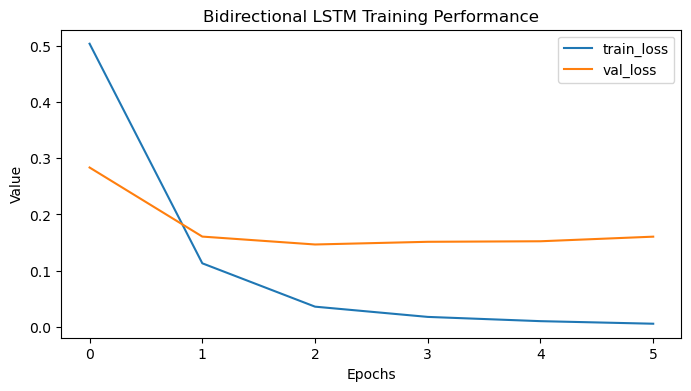

In [14]:
import matplotlib.pyplot as plt

def plot_history(history_bilstm, title):
    plt.figure(figsize=(8,4))
    plt.plot(history_bilstm.history['loss'], label='train_loss')
    plt.plot(history_bilstm.history['val_loss'], label='val_loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

plot_history(history_bilstm, "Bidirectional LSTM Training Performance")

In [13]:
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score

def evaluate_model(model, X, y_true, id2label):
    preds = model.predict(np.array(X))
    pred_tags = [[id2label[i] for i in np.argmax(p, axis=-1)] for p in preds]
    true_tags = [[id2label[i] for i in seq] for seq in y_true]

    print("Precision:", precision_score(true_tags, pred_tags))
    print("Recall:", recall_score(true_tags, pred_tags))
    print("F1-score:", f1_score(true_tags, pred_tags))
    print("\nDetailed Report:\n", classification_report(true_tags, pred_tags))

evaluate_model(model_bilstm, X_test, y_test, id2label)

116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step
Precision: 0.68212873067242
Recall: 0.6724565756823822
F1-score: 0.6772581220992503

Detailed Report:
               precision    recall  f1-score   support

         LOC       0.74      0.70      0.72      1665
        MISC       0.60      0.65      0.62       702
         ORG       0.69      0.64      0.66      1661
         PER       0.66      0.69      0.68      1614

   micro avg       0.68      0.67      0.68      5642
   macro avg       0.67      0.67      0.67      5642
weighted avg       0.68      0.67      0.68      5642



## making predictions

In [35]:
import numpy as np

sentence = ["The", "headquarters", "of", "the", "United", "Nations", "is", "in", "New", "York", "City", ",", "United", "States", "of", "America", "."]

word_ids = [vocab.get(w, vocab["<UNK>"]) for w in sentence]

word_ids = word_ids[:max_len] + [vocab["<PAD>"]] * (max_len - len(word_ids))

X_input = np.array([word_ids])

In [36]:
preds = model.predict(X_input)
pred_tags = np.argmax(preds, axis=-1)[0]

preds_bilstm = model_bilstm.predict(X_input)
pred_tags_bilstm = np.argmax(preds, axis=-1)[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


In [37]:
decoded_tags = [id2label[tag] for tag in pred_tags[:len(sentence)]]
for word, tag in zip(sentence, decoded_tags):
    print(f"{word} --> {tag}")

The --> O
headquarters --> O
of --> O
the --> O
United --> B-LOC
Nations --> I-ORG
is --> O
in --> O
New --> B-LOC
York --> I-LOC
City --> I-LOC
, --> O
United --> B-LOC
States --> I-LOC
of --> O
America --> B-LOC
. --> O


In [38]:
decoded_tags = [id2label[tag] for tag in pred_tags_bilstm[:len(sentence)]]
for word, tag in zip(sentence, decoded_tags):
    print(f"{word} --> {tag}")

The --> O
headquarters --> O
of --> O
the --> O
United --> B-LOC
Nations --> I-ORG
is --> O
in --> O
New --> B-LOC
York --> I-LOC
City --> I-LOC
, --> O
United --> B-LOC
States --> I-LOC
of --> O
America --> B-LOC
. --> O
